# Self-Report Sleep Prediction
In this modified analysis, we only consider the IAQ data from the beacon as features to attempt to predict the self-reported sleep quality metrics.

## Features
In this analysis, we are going to consider the following features:

**IAQ**: There are many measurements of IAQ that we consider:

    * CO$_2$
    * CO
    * PM$_{2.5}$
    * TVOCs
    * Temperature
    * Relative Humidity
    
## Targets
The targets will be all metrics related to sleep quality:

**Self-Report**: There are four metrics for self-report sleep quality reported via EMA:

    * TST
    * SOL
    * NAW
    * Restfulness

In [11]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
# timeseries
from datetime import datetime, timedelta
# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

<a id="toc"></a>

# Table of Contents
1. [Data Import](#data_import)
3. [Target Encoding](#encoding)
4. [Feature Engineering](#feature_engineering)
5. [Prediction](#prediction)
    1. [Fitbit Sleep Targets](#fitbit-sleep-prediction)
        1. TST
        2. SOL
        3. WASO
        4. REM:nREM
        5. SE
    2. [Self-Report Sleep Targets](#self-report-sleep-prediction)
        1. TST
        2. SOL
        3. NAW
        4. Restfulness
6. [Prediction with Encoded Features](#prediction_encoded)
7. [Final Analysis](#final_analysis)

<a id="data-import"></a>

---

<a id="data_import"></a>

# Data Import
For this analysis we want to only consider nights when we have _all_ the available data. These are also the nights that we have confirmed participants are home according to GPS traces. 

## Feature: IEQ
We start with IEQ data beacuse from previous analysis, this dataset has already been curated to include the relevant nights. However, there are quite a few columns that are not necessary for this analysis that have to be removed.

In [13]:
ieq_raw = pd.read_csv("../data/processed/beacon_by_night-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw.dropna(subset=["tvoc","co2","pm2p5_mass","co"],inplace=True)
ieq_raw = ieq_raw[(ieq_raw["home"] == 1) | (ieq_raw["increasing_co2"] > 0.5)]
ieq_raw.drop(["home","increasing_co2","ema","pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","no2","lux","beacon","redcap"],axis="columns",inplace=True)
ieq_raw = ieq_raw.groupby(["beiwe","start_time","end_time"]).median(numeric_only=None)
ieq_raw = ieq_raw.add_suffix("_median")
ieq_raw.reset_index(inplace=True)
ieq = ieq_raw.copy()
ieq["end_date"] =  pd.to_datetime(ieq["end_time"].dt.date)
ieq.head()

,beiwe,start_time,end_time,tvoc_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,fitbit_median,end_date
0,4i7679py,2020-07-06 07:29:30,2020-07-06 12:58:00,86.988188,6.887317,661.802117,23.723769,28.045646,51.900000,38.0,2020-07-06
1,4i7679py,2020-07-22 06:08:00,2020-07-22 09:46:30,87.556903,6.128722,634.789367,0.000000,28.045646,49.836667,38.0,2020-07-22
2,4i7679py,2020-07-30 05:42:30,2020-07-30 09:43:00,87.633434,6.097933,593.142571,0.000000,28.045646,51.753333,38.0,2020-07-30
3,4i7679py,2020-08-05 05:02:30,2020-08-05 09:52:30,59.919139,5.997469,590.241211,0.000000,28.045646,47.466667,38.0,2020-08-05
4,4i7679py,2020-08-06 05:53:00,2020-08-06 09:25:00,45.097536,5.981596,610.843120,35.778177,28.045646,49.030000,38.0,2020-08-06


## Target: Self-Report Sleep Quality (SRSQ)
The self-reported sleep quality comes from the morning EMAs.

In [14]:
srsq_raw = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
srsq_raw["end_date"] = pd.to_datetime(srsq_raw["timestamp"].dt.date)
srsq = srsq_raw[["timestamp","end_date","beiwe","redcap","beacon","tst","sol","naw","restful"]]
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful
0,2020-05-13 09:10:27,2020-05-13,qh34m4r9,68,19.0,8.0,20.0,2.0,3.0
1,2020-05-13 09:15:49,2020-05-13,awa8uces,28,26.0,2.0,10.0,3.0,1.0
2,2020-05-13 09:42:19,2020-05-13,xxvnhauv,21,22.0,6.0,30.0,3.0,1.0
3,2020-05-13 09:43:27,2020-05-13,rvhdl2la,29,NaN,5.3,5.0,2.0,2.0
4,2020-05-13 10:11:51,2020-05-13,q5y11ytm,48,NaN,2.0,10.0,0.0,0.0


[Back to Data Import](#data_import)

---

<a id="encoding" ></a>

[Back to ToC](#toc)
# Target Encoding
We will encode all the target sleep quality variables as binary where 0 represents poor/negative outcomes and 1 are good/positive outcomes.

In [15]:
def plot_distribution(df, variable,**kwargs):
    """plots distribution of values"""
    fig, ax = plt.subplots(figsize=(12,4))
    # density plot
    sns.kdeplot(x=variable,cut=0,data=df,zorder=2,
                linewidth=3,color="black",ax=ax)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.upper(),fontsize=16)
    if "xlim" in kwargs.keys():
        ax.set_xlim(kwargs["xlim"])
    else:
        ax.set_xlim([0,max(df[variable])])
    # cumulative
    ax2 = ax.twinx()
    sns.kdeplot(x=variable,cut=0,data=df,cumulative=True,zorder=1,
                linewidth=2,color="firebrick",ax=ax2)
    # y-axis
    ax.set_yticks([])
    ax.set_ylabel("")
    ax2.set_ylabel("")
    ax2.set_ylim([0,1])
    ax2.set_yticks([0,0.25,0.5,0.75,1])
    plt.yticks(fontsize=14)
    # remainder
    for loc in ["left","top"]:
        ax.spines[loc].set_visible(False)
        ax2.spines[loc].set_visible(False)
    plt.show()
    plt.close()

In [16]:
def plot_summary_count(df,params):
    """
    Plots a barplot of a binary responses
    
    Parameters
    ----------
    df : DataFrame
        data
    param : str
        parameter to inspect - must correspond to a column name in df
        
    Returns
    -------
    <void>
    """
    _, axes = plt.subplots(1,len(params),figsize=(4*len(params),4),sharey=True)
    for param, ax in zip(params,axes):
        # count
        sns.countplot(x=param,data=df,edgecolor="black",palette=["firebrick","seagreen"],ax=ax)
        # stats
        ax.text(0,len(df),f"Mean: {round(np.nanmean(df[param]),2)}",va="top",ha="center",fontsize=14)
        # x-axis
        ax.set_xlabel(param.split("_")[0].upper(),fontsize=16)
        # y-axis
        ax.set_ylabel("")
        ax.set_ylim([0,len(df)])
        # remainder
        ax.tick_params(labelsize=14)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
    axes[0].set_ylabel("Count",fontsize=16)
        
    plt.show()
    plt.close()

## TST
Based on a "traditional" recommendations, we can lump `tst` into three categories:

| TST | Rating | Value |
| --- | --- | --- |
| >9 h | High | 0 |
| 7-9 h | Typical | 1 |
| <7 h | Low | 0 |

In [17]:
def encode_tst(value):
    """returns score of tsts"""
    if value > 9:
        return 0
    elif value >= 7:
        return 1
    else:
        return 0

## SOL
The National Sleep Foundation says 30 minutes or less is a marker for good sleep quality. However, looking at the distribution of values, perhaps we should alter that threshold since many of the participants fall asleep faster than that.

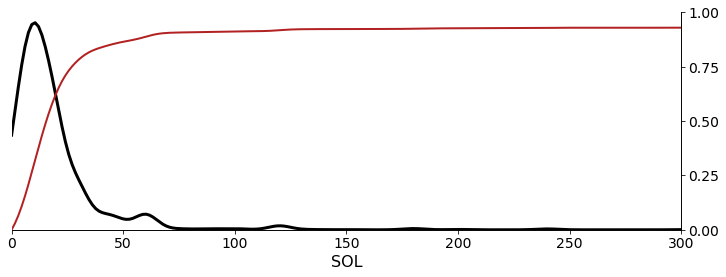

In [18]:
plot_distribution(srsq,"sol")

In [19]:
def encode_sol(value):
    """returns score of sol"""
    if value < 15:
        return 1
    else:
        return 0

## NAW
We group NAW into a good and bad category based on [Ohayon et al., 2017](https://www.sciencedirect.com/science/article/pii/S2352721816301309?casa_token=56p9duOGsL4AAAAA:tmPWLtzq0Z9zGGq-w0qWBXJT-VEDeoZ0dOwL06G-BwbWMHA3uT_KBjxd08HPyFZWNqIpm_0m).

| NAW | Rating | Value |
| --- | --- | --- |
| 0 or 1 | Good | 1 |
| >1 | Bad | 0 |

In [20]:
def encode_naw(value):
    """returns score of naw"""
    if value < 2:
        return 1
    else:
        return 0

## Restfulness
Restfulness is one of the five metrics that is rated on a 0 to 3 Likert scale. So we can create a more generic function here for later use.

In [21]:
def encode_likert(value):
    """returns score for a 0-3 Likert measurement"""
    if value > 1:
        return 1
    else:
        return 0

## Encoding Self-Report Sleep Quality
We start with self-report metrics of sleep quality.

In [22]:
for sm, f in zip(["tst","sol","naw","restful"], [encode_tst,encode_sol,encode_naw,encode_likert]):
    srsq[f"{sm}_binary"] = srsq.apply(lambda x: f(x[sm]), axis="columns")
    
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful,tst_binary,sol_binary,naw_binary,restful_binary
0,2020-05-13 09:10:27,2020-05-13,qh34m4r9,68,19.0,8.0,20.0,2.0,3.0,1,0,0,1
1,2020-05-13 09:15:49,2020-05-13,awa8uces,28,26.0,2.0,10.0,3.0,1.0,0,1,0,0
2,2020-05-13 09:42:19,2020-05-13,xxvnhauv,21,22.0,6.0,30.0,3.0,1.0,0,0,0,0
3,2020-05-13 09:43:27,2020-05-13,rvhdl2la,29,NaN,5.3,5.0,2.0,2.0,0,1,0,1
4,2020-05-13 10:11:51,2020-05-13,q5y11ytm,48,NaN,2.0,10.0,0.0,0.0,0,1,1,0


### Inspecting Distribution of Observations

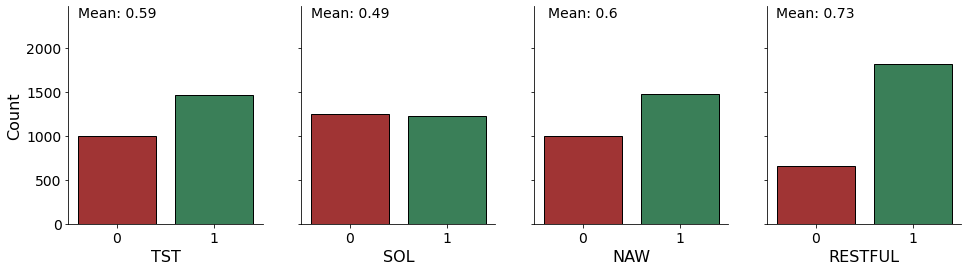

In [23]:
plot_summary_count(srsq,["tst_binary","sol_binary","naw_binary","restful_binary"])

[Back to Encoding](#encoding)

---

<a id="feature_engineering" ></a>

[Back to ToC](#toc)
# Feature Engineering
In the following cells, we encode the various features to binary outcomes and combine the features into one dataset. 

## Encoding IAQ
For the IEQ data, we want to determine whether the concentrations are low or high depending on the participant's own environment. So the process will involve looking at each of the IEQ measurements from each participant, finding the mean of those nights, and then determining 1 (low) or 0 (high).

In [24]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return 1
    else:
        return 0

### Thresholds

In [25]:
thresholds = {"co2":1100,"co":4,"tvoc":200,"pm2p5_mass":6,"temperature_c":25.2,"rh":40}

### Encoding

In [26]:
ieq_bi = pd.DataFrame()
stat="median"
for pt in ieq["beiwe"].unique():
    ieq_pt = ieq[ieq["beiwe"] == pt]
    for pollutant in ["co2", "co","tvoc","pm2p5_mass","temperature_c","rh"]:
        stat_per_night = np.nanmedian(ieq_pt[f"{pollutant}_{stat}"])
        ieq_pt[f"{pollutant}_{stat}_binary"] = ieq_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_{stat}"],stat_per_night), axis="columns")
        
    ieq_bi = ieq_bi.append(ieq_pt)
    
ieq_bi.head()

,beiwe,start_time,end_time,tvoc_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,fitbit_median,end_date,co2_median_binary,co_median_binary,tvoc_median_binary,pm2p5_mass_median_binary,temperature_c_median_binary,rh_median_binary
0,4i7679py,2020-07-06 07:29:30,2020-07-06 12:58:00,86.988188,6.887317,661.802117,23.723769,28.045646,51.900000,38.0,2020-07-06,0,0,0,0,1,0
1,4i7679py,2020-07-22 06:08:00,2020-07-22 09:46:30,87.556903,6.128722,634.789367,0.000000,28.045646,49.836667,38.0,2020-07-22,0,0,0,1,1,0
2,4i7679py,2020-07-30 05:42:30,2020-07-30 09:43:00,87.633434,6.097933,593.142571,0.000000,28.045646,51.753333,38.0,2020-07-30,1,0,0,1,1,0
3,4i7679py,2020-08-05 05:02:30,2020-08-05 09:52:30,59.919139,5.997469,590.241211,0.000000,28.045646,47.466667,38.0,2020-08-05,1,1,1,1,1,1
4,4i7679py,2020-08-06 05:53:00,2020-08-06 09:25:00,45.097536,5.981596,610.843120,35.778177,28.045646,49.030000,38.0,2020-08-06,1,1,1,0,1,1


### Inspecting IAQ Outcomes

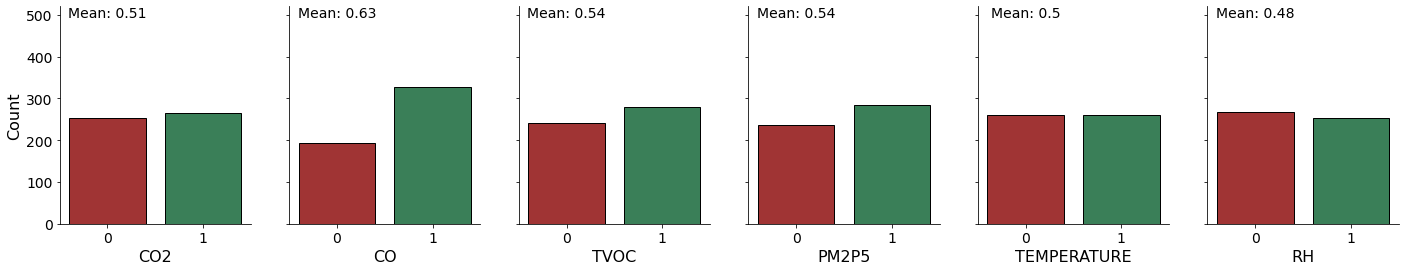

In [27]:
plot_summary_count(ieq_bi,["co2_median_binary","co_median_binary","tvoc_median_binary","pm2p5_mass_median_binary","temperature_c_median_binary","rh_median_binary"])

[Back to Feature Engineering](#feature_engineering)

---

<a id="exploration"></a>

[Back to ToC](#toc)
# Data Exploration
Now that we have our features and targets, we can look at the data to get a better sense of what we can do with it.

We have to start by combining the features and targets so that we are looking at the finalized dataset.

In [28]:
ieq_srsq = ieq.merge(right=srsq,on=["end_date","beiwe"])
ieq_srsq = ieq_srsq[ieq_srsq["end_time"] < ieq_srsq["timestamp"]]
data = pd.DataFrame()
for pt in ieq_srsq["beiwe"].unique():
    data_pt = ieq_srsq[ieq_srsq['beiwe'] == pt]
    if len(data_pt) > 3:
        print(f"{pt}:{len(data_pt)}")
        data = data.append(data_pt)
print("Number of Observations:", len(data))
print("Number of Participants:", len(data["beiwe"].unique()))

745vq78e:8
9jtzsuu8:18
awa8uces:16
i31pt4b4:9
itmylz3g:11
kyj367pi:13
lkkjddam:39
olaxadz5:13
qh34m4r9:25
rnse61g4:4
tlmlq19s:37
tmexej5v:22
vr9j5rry:22
xdbdrk6e:4
xlw5ntd5:4
zdpffrox:13
Number of Observations: 258
Number of Participants: 16


[Back to Data Exploration](#data_exploration)

---

<a id="prediction"></a>

# Prediction
Now that we have sufficiently explored the features, we can begin to try predicting various components of sleep quality. We will try a wide-variety of classifiers to determine which is the most applicable to solving our problem. The classifiers that we use can be seen in the following cell via the `import` statements.

## Classification

In [29]:
# Logistic Regressions
from sklearn.linear_model import LogisticRegression
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB, GaussianNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Support Vector
from sklearn.svm import SVC
# Multi-Layer Perceptron
from sklearn.neural_network import MLPClassifier
# ADAboost
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# Bagging
from sklearn.ensemble import BaggingClassifier

To automate the prediction/evaluation process, we have created the class below that utilizes the following steps:
1. Feature and Target Data Split: The feature and target datasets are fed into the program, cross-referenced, and then split.
2. Train/Test Split: Data are split into a training and a testing split

In [75]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold, GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, f1_score, precision_recall_curve, plot_precision_recall_curve, accuracy_score, balanced_accuracy_score, recall_score, precision_score
from sklearn.inspection import permutation_importance

class ieq_and_sq_prediction:
    
    def __init__(self):
        """initializes the model parameters"""
        self.classifier_model_params = {
            "logistic_regression": {
                "model":LogisticRegression(random_state=42,max_iter=500),
                "params": {
                    "fit_intercept":[True,False],
                    "solver":["lbfgs","liblinear"],
                }
            },
            "decision_tree":{
                "model": DecisionTreeClassifier(random_state=42,criterion="gini"),
                "params": {
                    "ccp_alpha":np.arange(0,0.1,0.005),
                    "max_depth":[1,2,3,4,5,6,7,8],
                }
            },
            "random_forest":{
                "model": RandomForestClassifier(random_state=42,criterion="gini"),
                "params": {
                    "criterion":["gini","entropy"],
                    "ccp_alpha":np.arange(0,0.1,0.01),
                    "n_estimators":[10,20,30,40,50],
                    "max_depth":[1,2,3,4,5,6],
                }
            },
            "naive_bayes": {
                "model":GaussianNB(),
                "params": {
                }
            }
        }

        self.tuned_models = {"logistic_regression":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs",max_iter=500),
                             "naive_bayes":GaussianNB(),
                             "decision_tree":DecisionTreeClassifier(random_state=42,ccp_alpha=0,max_depth=6),
                             "random_forest":RandomForestClassifier(random_state=42,ccp_alpha=0,n_estimators=10,max_depth=6)}
    
    def get_features_and_targets(self, feature_set, target_set, target="tst"):
        """gets feature set and target set for the same observations"""
        self.target_label = target
        print(f"Getting Features and Target ({target})...")
        # selecting only important target
        target_set_reduced = target_set[["beiwe","end_date",f"{target}_binary"]]
        # combining datasets to get overlapping observations
        combined = feature_set.merge(right=target_set_reduced,on=["beiwe","end_date"])
        combined = combined.merge(right=combined["beiwe"].value_counts().rename("count"),left_on="beiwe",right_index=True,how="left")
        combined = combined[combined["count"] > 1]
        combined_simple = combined[[column for column in combined.columns if column.endswith("binary") or column in ["count","beiwe"]]]
        # splitting into features and targets
        targets = combined_simple[[f"{target}_binary"]]
        features = combined_simple.drop([f"{target}_binary","beiwe"],axis="columns")
        self.groups = combined_simple["beiwe"]
        self.counts = features["count"]
        self.features = features.drop(["count"],axis="columns")
        self.targets = targets
        
    def split_data(self, test_size=0.33):
        """splits data into training and testing"""
        print("Splitting Data...")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets, test_size=test_size, random_state=10, stratify=self.counts)
        #self.X_train.drop("count",axis="columns",inplace=True)
        #self.X_test.drop("count",axis="columns",inplace=True)
        
    def set_test_and_train(self,X_train,X_test,y_train,y_test):
        """sets the training data - use for specialized train_test_split"""
        for dataset in [X_train,X_test,y_train,y_test]:
            try: 
                dataset.drop(["count"],axis="columns",inplace=True)
            except KeyError:
                pass
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def set_weights(self,**kwargs):
        """sets the weights based on the y_train data"""
        if "y_train" in kwargs.keys():
            self.y_train = kwargs["y_train"]
        try:
            low_n = self.y_train.value_counts().sort_index().iloc[0]
            high_n = self.y_train.value_counts().sort_index().iloc[1]
            self.weights = [len(self.y_train) / (2 * low_n) if val == 0 else len(self.y_train) / (2 * high_n) for val in self.y_train[f"{target}_binary"]]
        except Exception as e:
            print(e)
            self.weights = None # defaults to None so the fit() function will work
        
    def optimize_models(self):
        """runs gridsearch cv"""
        print("Testing Classifiers...")
        try:
            scores = []
            params = self.classifier_model_params
            self.set_weights()
            for model_name, mp in params.items():
                s = datetime.now()
                print(f"\t{model_name.replace('_',' ').title()}")
                clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
                clf.fit(self.X_train,self.y_train,self.weights)
                scores.append({
                    "model":model_name,
                    "best_score":clf.best_score_,
                    "best_params":clf.best_params_
                })
                print("\t\tElapsed Time:\t", datetime.now() - s)
                print(f"\t\tBest Score:\t{clf.best_score_}\n\t\tBest Params:\t{clf.best_params_}")

            results = pd.DataFrame(scores,columns=["model","best_score","best_params"])
            # getting and saving best model
            results.sort_values(["best_score"],ascending=False,inplace=True)
            self.results = results
            best = results.iloc[0,:]
            # outputting results
            print(f"\tBest Scoring Model:")
            print(f"\t\tModel:\t{best[0].replace('_',' ').title()}\n\t\tScore:\t{round(best[1],3)}\n\t\tParams:\t{best[2]}")
        except AttributeError:
            print("Training data do not exist - run split_data()")
        
    def train_model(self, model):
        """trains the specified model"""
        print("Training...")
        self.model = model # necessary if running functions separately
        try:
            self.set_weights()
            self.X_train = self.X_train
            self.X_test = self.X_test
            try:
                self.model.fit(self.X_train,self.y_train,self.weights)
            except TypeError:
                self.model.fit(self.X_train,self.y_train)
        except AttributeError:
            print("Training data do not exist - run split_data()")
    
    def predict(self):
        """gets the predicted results based on the model provided for the given target"""
        print("Predicting...")
        try:
            self.predictions = self.model.predict(self.X_test)
            
            self.score = metrics.precision_score(self.y_test,self.predictions,average="weighted")

            scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='precision_weighted')
            print("\tCross Validation Scores:")
            for scr in scores:
                print(f"\t\t{round(scr,3)}")
            print(f"\tAverage:\t{round(scores.mean(),3)}")
            print(f"\tModel Score: {round(self.score,3)}")
        except AttributeError:
            print("Missing attributes - make sure you split the data and trained the model")
        
    def plot_confusion_matrix(self, save=False, target_label=""):
        """plots confusion matrix"""
        print("Evaluating...")
        # get confusion matrix
        cm = metrics.confusion_matrix(self.y_test,self.predictions)
        cm_df = pd.DataFrame(cm)
        # plot confusion matrix as heatmap
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
        ax.set_xlabel("Predicted Label",fontsize=16)
        ax.set_ylabel("True Label",fontsize=16)
        if save:
            plt.savefig(f"../../../Documents/sbac_2021/project/figures/confusion_matrix-{target_label}.pdf")
        plt.show()
        plt.close()
        
    def set_feature_importance(self,plot=False):
        """gets feature importance from classifier models"""
        try:
            # getting importance df
            importance = pd.DataFrame(data={"feature":[value.split('_')[0] for value in self.features.columns],"importance":self.model.feature_importances_})
            importance.sort_values("importance",inplace=True)
            self.feature_importance = importance
            if plot:
                # getting color map
                my_cmap = plt.get_cmap("Blues")
                rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
                # plotting
                fig, ax = plt.subplots(figsize=(6,4))
                ax.barh(importance["feature"],importance["importance"],color=my_cmap(rescale(importance["importance"])),edgecolor="black",tick_label=[visualize.get_label(label) for label in importance["feature"]])
                # x-axis
                plt.xticks(fontsize=12)
                ax.set_xlabel("Importance",fontsize=14)
                # y-axis
                plt.yticks(fontsize=12)
                ax.set_ylabel("Feature",fontsize=14)
                # remainder
                for loc in ["top","right"]:
                    ax.spines[loc].set_visible(False)
                plt.show()
                plt.close()
        except AttributeError as e:
            print(e)
            
    def get_permutation_importance(self,scoring="accuracy"):
        """"""
        self.set_weights()
        res_dict = {}
        for model_name, mp in self.tuned_models.items():
            try:
                clf = mp.fit(self.X_train,self.y_train,self.weights)
            except TypeError:
                clf = mp.fit(self.X_train,self.y_train)
            res = permutation_importance(clf, self.X_test, self.y_test, n_repeats=10,random_state=42,scoring=scoring)
            vals = [0 if m < 0 else m for m in res.importances_mean]
            res_dict[model_name] = vals
        return res_dict
            
    def run(self, feature_set, target_set, target="tst", test_size=0.33):
        """runs the class: split, test, predict, evaluate"""
        self.get_features_and_targets(feature_set, target_set, target=target)
        self.split_data(test_size=test_size)
        # gridsearch on models
        self.optimize_models()
        # saves the best model, trains on the best model, predicts with the model, and plots the confusion matrix
        for model_number in range(len(self.results)):
            print(self.results.iloc[model_number,0].replace("_"," ").upper())
            self.model = self.classifier_model_params[self.results.iloc[model_number,:]["model"]]["model"].set_params(**self.results.iloc[model_number,:]["best_params"])
            self.train_model(self.model)
            self.predict()
            self.plot_confusion_matrix()
            self.set_feature_importance(plot=True)
            
    def get_cv(self,validation="",splits=5):
        """gets cv object"""
        if validation == "gkf":
            return GroupKFold(n_splits=splits)
        elif validation == "logo":
            return LeaveOneGroupOut()
        elif validation == "skf":
            return StratifiedKFold(n_splits=splits)
        else:
            return KFold(n_splits=splits)        
            
    def plot_roc_auc(self,validation="gkf",splits=5,save=False,**kwargs):
        """Trains the tuned models and cross-validates"""
        cv = self.get_cv(validation,splits)
            
        fig, axes = plt.subplots(1,len(self.tuned_models.keys()),figsize=(6*len(self.tuned_models.keys()),6),sharey=True)
        for (name, model), ax in zip(self.tuned_models.items(),axes.flat):
            tprs = []
            aucs = []
            f1s = []
            mean_fpr = np.linspace(0, 1, 100)
            for i, (train, test) in enumerate(cv.split(self.features, self.targets, groups=self.groups)):
                clf = model.fit(self.features.iloc[train],self.targets.iloc[train])
                scores = clf.predict(self.features.iloc[test])
                try:
                    fpr, tpr, thresholds = roc_curve(self.targets.iloc[test], clf.predict_proba(self.features.iloc[test])[:, 1])
                    auc_score = roc_auc_score(self.targets.iloc[test], clf.predict_proba(self.features.iloc[test])[:, 1])
                    f1 = f1_score(self.targets.iloc[test], scores)
                    if validation != "logo":
                        ax.plot(fpr,tpr,lw=1,alpha=0.5,label=f"Fold {i+1}")
                    interp_tpr = np.interp(mean_fpr, fpr, tpr)
                    interp_tpr[0] = 0.0
                    tprs.append(interp_tpr)
                    aucs.append(auc_score)
                    f1s.append(f1)
                except ValueError as e:
                    print(e)
                
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color='black',label=f'Mean ROC',lw=3, alpha=.8)#\n')
            ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
            if name not in ["knn"]:
                ax.set_title(f'{name.replace("_"," ").title()}',fontsize=16)
            else:
                ax.set_title(f'KNN',fontsize=16)
            plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            ax.legend(frameon=True,loc="lower right",bbox_to_anchor=(1.2,0),fontsize=12,)
            # annotations
            ax.text(0.0,0.9,f"AUC = {round(mean_auc,2)} $\pm$ {round(std_auc,2)}",fontsize=14)
        if save:
            plt.savefig(f"../reports/conferences/BuildSys_2021/{self.target_label}-{validation}cv-roc_curve.pdf")
            
        if "annote" in kwargs.keys():
            axes[0].text(0.05,1,kwargs["annote"],va="bottom",ha="left",fontsize=24)
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        plt.xlabel("False Positive Rate",fontsize=15)
        plt.ylabel("True Positive Rate",fontsize=15)
        plt.show()
        plt.close()
        
    def find_accuracy_threshold(self):
        """"""
        fig, axes = plt.subplots(1,len(self.tuned_models.keys()),figsize=(6*len(self.tuned_models.keys()),6),sharey=True)
        for (name, model), ax in zip(self.tuned_models.items(),axes.flat):
            clf = model.fit(self.X_train,self.y_train)
            y_pred_pos = clf.predict_proba(self.X_test)[:,1]
            thresholds = []
            accs = []
            for threshold in np.linspace(0,1,100):
                thresholds.append(threshold)
                y_pred_class = y_pred_pos > threshold
                acc = accuracy_score(self.y_test, y_pred_class)
                accs.append(acc)
            ax.plot(thresholds,accs,color="black",lw=2)
            ix = np.argmax(accs)
            ax.set_title(thresholds[ix])
        plt.show()
        plt.close()

    def get_res(self,cv="gkf",splits=5,save=False):
        """Gets the performance metrics of the model and prediction"""
        # getting cross-validation funciton
        cv = self.get_cv(cv,splits)
        # defining result dicts
        model_res = {"target":[],"model":[],"accuracy":[],"accuracy_naive":[],"f1":[],"f1_naive":[]}
        pred_res = {"target":[],"model":[],"accuracy":[],"accuracy_naive":[],"f1":[],"f1_naive":[]}
        final_feature_importances = {new_list: [] for new_list in self.tuned_models.keys()}
        # looping through models
        for name, model in self.tuned_models.items():
            # pre-allocating empty metric lists
            precisions = {"train":[],"test":[]}
            thresholds = {"train":[],"test":[]}
            accuracies = {"train":[],"test":[]}
            mean_recall = np.linspace(0, 1, 100)
            feature_importances = []
            # looping through cv folds
            print("Total:",len(self.features))
            for i, (train, test) in enumerate(cv.split(self.features, self.targets, groups=self.groups)):
                #print(f"Train ({len(train)}): {len(train)/(len(train)+len(test))} - Good: {self.targets.iloc[train].sum()/len(self.targets.iloc[train])}")
                #print(f"Test ({len(test)}):", len(test)/(len(train)+len(test)))
                # training model
                clf = model.fit(self.features.iloc[train],self.targets.iloc[train])
                # metrics for model (train) and prediction (test)
                for set_label,set_locs in zip(["train","test"],[train,test]):
                    # getting precision, thresholds, and f1_balanced (0.5 cutoff)
                    precision, recall, threshold = precision_recall_curve(self.targets.iloc[set_locs], clf.predict_proba(self.features.iloc[set_locs])[:, 1])
                    precisions[set_label].append(np.interp(mean_recall, np.sort(recall), precision))
                    thresholds[set_label].append(np.interp(mean_recall, np.sort(recall), np.append(threshold,[1])))
                    # accuracy
                    accuracies[set_label].append(accuracy_score(self.targets.iloc[set_locs],clf.predict(self.features.iloc[set_locs])))
            
                # feature importances 
                if name in ["decision_tree","random_forest"]:
                    feature_importances.append(clf.feature_importances_)
                elif name == "logistic_regression":
                    feature_importances.append(clf.coef_[0])
                else:
                    feature_importances.append(np.zeros(len(self.features.columns)))
            
            # averaging feature importances from cv folds
            final_feature_importances[name] = pd.DataFrame(data=feature_importances).mean(axis=0).values
            for set_label,set_res in zip(["train","test"],[model_res,pred_res]):
                # getting adjusted f1 score
                mean_precision = np.mean(precisions[set_label], axis=0)
                mean_threshold = np.mean(thresholds[set_label], axis=0)
                fscore = (2 * mean_precision * mean_recall[::-1]) / (mean_precision + mean_recall[::-1])
                ix = np.argmax(fscore) # locate the index of the largest f score
                # getting averaged metrics
                acc_temp = round(np.mean(accuracies[set_label]),2)
                score = round(sum(self.targets.iloc[:,0])/len(self.targets),2)
                acc_naive_temp = score if score > 0.5 else 1-score
                f1_temp = f"{round(fscore[ix],2)} ({round(mean_threshold[ix],2)})"
                f1_naive_temp = round(f1_score(self.targets,np.ones(len(self.targets))),2)
                # adding to dict
                for key,val in zip(set_res.keys(),[self.targets.columns.values[0],name,acc_temp,acc_naive_temp,f1_temp,f1_naive_temp]):
                    set_res[key].append(val)
            
        return pd.DataFrame(model_res), pd.DataFrame(pred_res), final_feature_importances
    

## Optimizing Models
Looking at different components of:
* classifiers
* validation
* hyperparameters

### Aggregate
All the participants' data considered and stratified according to the number of observations.

Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.104268
		Best Score:	0.6486486486486487
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Decision Tree
		Elapsed Time:	 0:00:03.778599
		Best Score:	0.6707207207207206
		Best Params:	{'ccp_alpha': 0.0, 'max_depth': 3}
	Random Forest
		Elapsed Time:	 0:01:59.873726
		Best Score:	0.6594594594594595
		Best Params:	{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 4, 'n_estimators': 40}
	Naive Bayes
		Elapsed Time:	 0:00:00.022433
		Best Score:	0.6430930930930931
		Best Params:	{}
	Best Scoring Model:
		Model:	Decision Tree
		Score:	0.671
		Params:	{'ccp_alpha': 0.0, 'max_depth': 3}
DECISION TREE
Training...
Predicting...
	Cross Validation Scores:
		0.501
		0.657
		0.687
		0.688
		0.71
	Average:	0.648
	Model Score: 0.53
Evaluating...


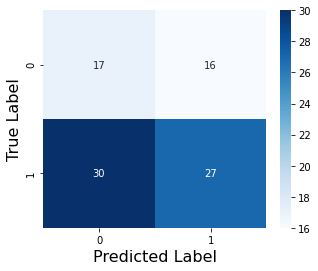

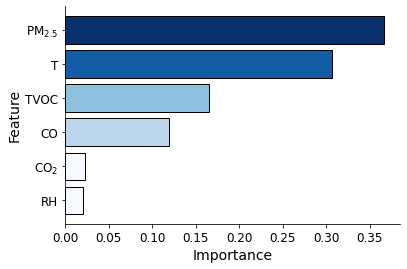

RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.501
		0.695
		0.556
		0.71
		0.688
	Average:	0.63
	Model Score: 0.491
Evaluating...


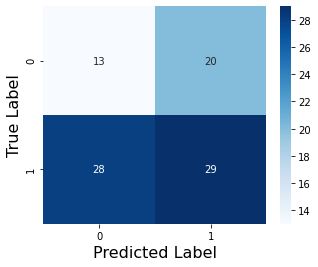

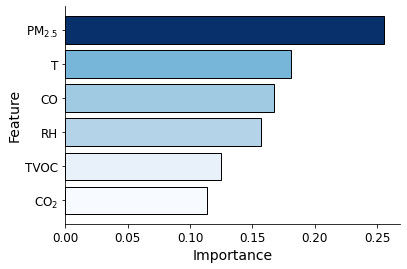

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.501
		0.421
		0.804
		0.408
		0.408
	Average:	0.508
	Model Score: 0.502
Evaluating...


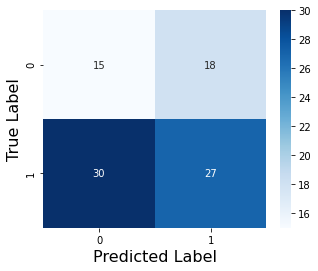

'LogisticRegression' object has no attribute 'feature_importances_'
NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.501
		0.421
		0.79
		0.408
		0.408
	Average:	0.506
	Model Score: 0.494
Evaluating...


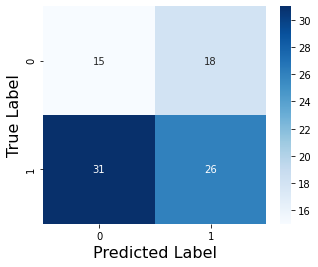

'GaussianNB' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.097894
		Best Score:	0.4774774774774775
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Decision Tree
		Elapsed Time:	 0:00:03.611119
		Best Score:	0.543993993993994
		Best Params:	{'ccp_alpha': 0.015, 'max_depth': 1}
	Random Forest
		Elapsed Time:	 0:01:56.741849
		Best Score:	0.5495495495495496
		Best Params:	{'ccp_alpha': 0.02, 'criterion': 'entropy', 'max_depth': 1, 'n_estimators': 20}
	Naive Bayes
		Elapsed Time:	 0:00:00.028326
		Best Score:	0.47762762762762756
		Best Params:	{}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.55
		Params:	{'ccp_alpha': 0.02, 'criterion': 'entropy', 'max_depth': 1, 'n_estimators': 20}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.292
		0.292
		0.279
		0.309
		0.762
	Average:	0.387
	Model Score: 0.498
Evaluating...


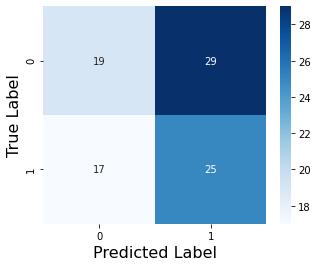

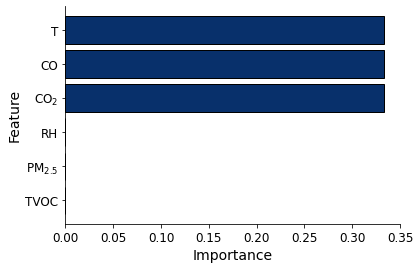

DECISION TREE
Training...
Predicting...
	Cross Validation Scores:
		0.292
		0.292
		0.279
		0.309
		0.309
	Average:	0.296
	Model Score: 0.284
Evaluating...


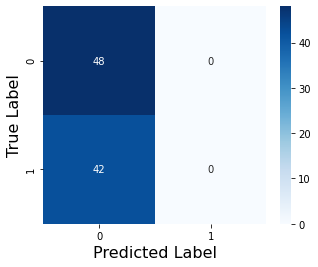

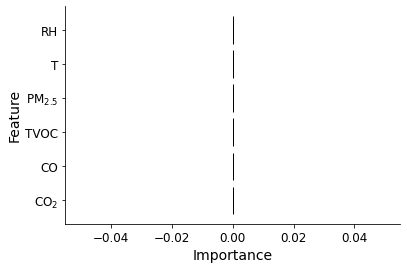

NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.509
		0.505
		0.453
		0.469
		0.388
	Average:	0.465
	Model Score: 0.577
Evaluating...


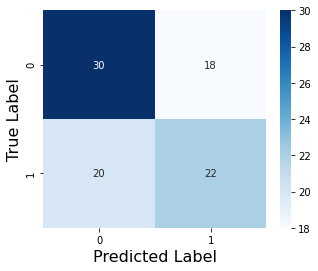

'GaussianNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.509
		0.528
		0.304
		0.469
		0.436
	Average:	0.449
	Model Score: 0.576
Evaluating...


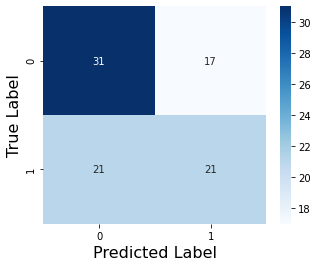

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.168129
		Best Score:	0.5498498498498499
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Decision Tree
		Elapsed Time:	 0:00:03.767243
		Best Score:	0.5495495495495495
		Best Params:	{'ccp_alpha': 0.01, 'max_depth': 1}
	Random Forest
		Elapsed Time:	 0:01:57.717663
		Best Score:	0.5495495495495495
		Best Params:	{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 1, 'n_estimators': 30}
	Naive Bayes
		Elapsed Time:	 0:00:00.024437
		Best Score:	0.47822822822822825
		Best Params:	{}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.55
		Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.532
		0.278
		0.638
		0.486
		0.576
	Average:	0.502
	Model Score: 0.567
Evaluating...


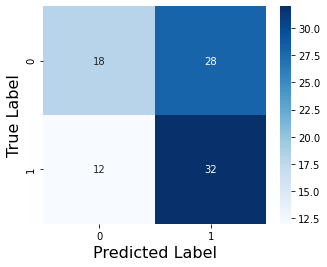

'LogisticRegression' object has no attribute 'feature_importances_'
DECISION TREE
Training...
Predicting...
	Cross Validation Scores:
		0.292
		0.292
		0.309
		0.309
		0.309
	Average:	0.302
	Model Score: 0.261
Evaluating...


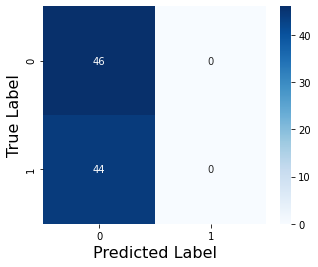

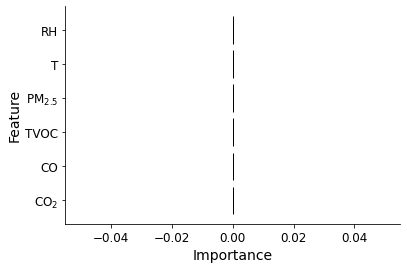

RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.292
		0.292
		0.309
		0.309
		0.309
	Average:	0.302
	Model Score: 0.525
Evaluating...


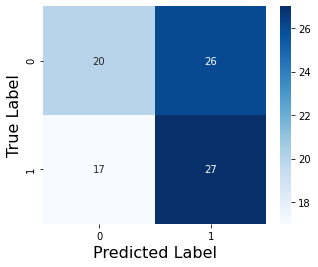

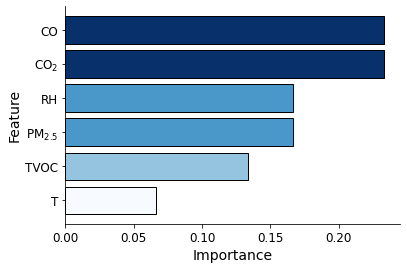

NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.423
		0.27
		0.497
		0.486
		0.389
	Average:	0.413
	Model Score: 0.535
Evaluating...


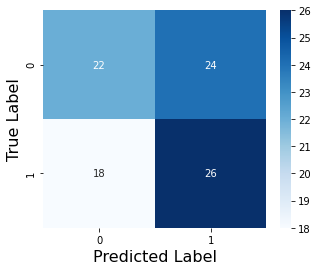

'GaussianNB' object has no attribute 'feature_importances_'
Getting Features and Target (restful)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.173462
		Best Score:	0.8406906906906908
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Decision Tree
		Elapsed Time:	 0:00:04.038945
		Best Score:	0.8406906906906908
		Best Params:	{'ccp_alpha': 0.0, 'max_depth': 1}
	Random Forest
		Elapsed Time:	 0:01:51.770804
		Best Score:	0.8406906906906908
		Best Params:	{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 1, 'n_estimators': 10}
	Naive Bayes
		Elapsed Time:	 0:00:00.024810
		Best Score:	0.8406906906906908
		Best Params:	{}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.841
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.702
		0.702
		0.742
		0.694
		0.694
	Average:	0.707
	Model Score: 0.724
Evaluating...


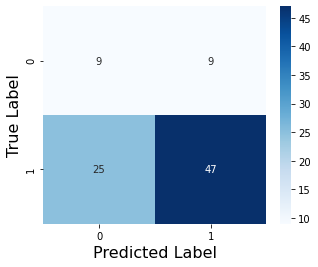

'LogisticRegression' object has no attribute 'feature_importances_'
DECISION TREE
Training...
Predicting...
	Cross Validation Scores:
		0.702
		0.702
		0.742
		0.694
		0.694
	Average:	0.707
	Model Score: 0.717
Evaluating...


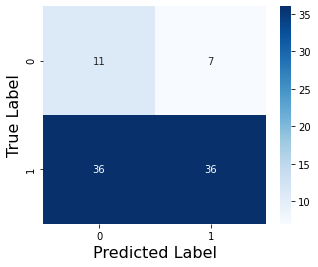

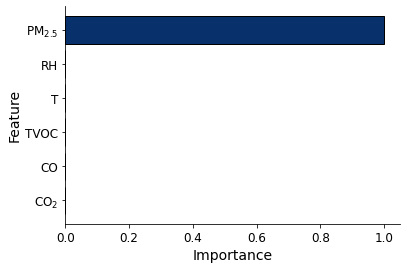

RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.702
		0.702
		0.742
		0.694
		0.694
	Average:	0.707
	Model Score: 0.717
Evaluating...


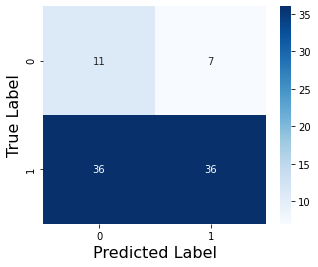

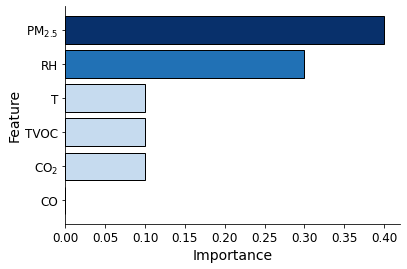

NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.702
		0.702
		0.742
		0.694
		0.694
	Average:	0.707
	Model Score: 0.717
Evaluating...


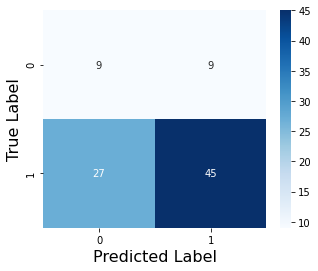

'GaussianNB' object has no attribute 'feature_importances_'


In [43]:
agg_pred = ieq_and_sq_prediction()
agg_res = {"target":[],"best_performing_model":[],"model":[],"model_score":[],"biased_score":[],"hyper_parameters":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for target in ["tst","sol","naw","restful"]:
    agg_pred.run(ieq_bi,srsq,target)
    for i in range(len(agg_pred.results)):
        agg_res["target"].append(target)
        agg_res["best_performing_model"].append(agg_pred.results.iloc[0,0])
        agg_res["model"].append(agg_pred.results.iloc[i,0])
        agg_res["model_score"].append(agg_pred.results.iloc[i,1])
        bs = sum(agg_pred.targets.values)/len(agg_pred.targets)
        agg_res["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
        agg_res["hyper_parameters"].append(agg_pred.results.iloc[i,2])
        try:
            agg_res["sensitive_parameter1"].append(agg_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
            agg_res["sensitive_parameter2"].append(agg_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
        except KeyError:
            agg_res["sensitive_parameter1"].append(np.nan)
            agg_res["sensitive_parameter2"].append(np.nan)

In [32]:
agg_res_df = pd.DataFrame(agg_res)
agg_res_df

,target,best_performing_model,model,model_score,biased_score,hyper_parameters,sensitive_parameter1,sensitive_parameter2
0,tst,decision_tree,decision_tree,0.670721,0.643382,"{'ccp_alpha': 0.0, 'max_depth': 3}",pm2p5,temperature
1,tst,decision_tree,random_forest,0.659459,0.643382,"{'ccp_alpha': 0.0, 'max_depth': 4, 'n_estimato...",pm2p5,temperature
2,tst,decision_tree,logistic_regression,0.648649,0.643382,"{'fit_intercept': True, 'solver': 'lbfgs'}",pm2p5,temperature
3,tst,decision_tree,naive_bayes,0.643093,0.643382,{},pm2p5,temperature
4,sol,random_forest,random_forest,0.549399,0.518382,"{'ccp_alpha': 0.0, 'max_depth': 1, 'n_estimato...",co2,co
5,sol,random_forest,decision_tree,0.543994,0.518382,"{'ccp_alpha': 0.015, 'max_depth': 1}",co2,co
6,sol,random_forest,naive_bayes,0.477628,0.518382,{},co2,co
7,sol,random_forest,logistic_regression,0.477477,0.518382,"{'fit_intercept': True, 'solver': 'liblinear'}",co2,co
8,naw,logistic_regression,logistic_regression,0.549850,0.529412,"{'fit_intercept': False, 'solver': 'lbfgs'}",co2,co
9,naw,logistic_regression,decision_tree,0.549550,0.529412,"{'ccp_alpha': 0.01, 'max_depth': 1}",co2,co


The following hyperparameters will be used:
* **Logistic Regression**: (fit_intercpt=True,solver="lbfgs")
* **Decision Tree**: (ccp_alpha=0.01,max_depth=2)
* **Naive Bayes**: None
* **Random Forest**: (ccp_alpha=0.02,max_depth=2,n_esimators=30)

## Model Performance 

### Summary of Measurements

In [28]:
ieq_srsq = srsq.merge(ieq_bi,on=["beiwe","end_date"])

In [56]:
def plot_summary(df_in,save=False):
    """
    Plots simplifed kde plots of the variables
    """
    df = df_in.copy()
    #df = df[[col for col in df.columns if col.endswith("median")]]
    df = df[["co2_median","pm2p5_mass_median","temperature_c_median","rh_median","tvoc_median","co_median"]]
    df.rename({"co2_median":"CO$_2$ (ppm)","pm2p5_mass_median":"PM$_{2.5}$ ($\mu$g/m$^3$)","temperature_c_median":"T ($^\circ$C)","rh_median":"RH (%)","tvoc_median":"TVOC (ppb)","co_median":"CO (ppb)"},axis="columns",inplace=True)
    #df.rename({"CO2_ETC_BR1":"CO2_BR (ppm)", "RH_ETC_IN1":"RH (%)", "PM_MET_IN1":"PM_IN ($\mu$g/m$^3$)", "NO2_IAQm_ppb":"NO2 (ppb)", "FRM_IN_ppb":"FRM (ppb)", "T_ETC_IN1":"T_IN ($^\circ$C)",
    #             "RHD_Fan_Airflow_Adjusted_Low_cfm":"RHD_Low (CFM)","Depressurization_Q50_cfm":"Q50 (CFM)", "EXF_BA1_Measured_cfm":"EXF_BA (CFM)"},axis="columns",inplace=True)
    _, axes = plt.subplots(3,2,figsize=(4,6),gridspec_kw={"hspace":0.6})
    for param, ticks, ax in zip(df.columns,[[500,1500,2500],[0,10,20,30,40,50],[15,20,25,30],[30,40,50],[0,300,600,900],[0,5,10,15]],axes.flat):
        sns.kdeplot(df[param],cumulative=False,cut=0,common_norm=True,color="black",lw=2,ax=ax)
        for loc in ["top","left","right"]:
            ax.set_xticks(ticks)
            ax.spines[loc].set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            
        ax.set_xlabel(ax.get_xlabel(),size=10)
        ax.tick_params(labelsize=8)
            
    if save:
        plt.savefig("../reports/figures/prediction/sleep_quality-distributions.pdf",bbox_inches="tight")

    plt.show()
    plt.close()

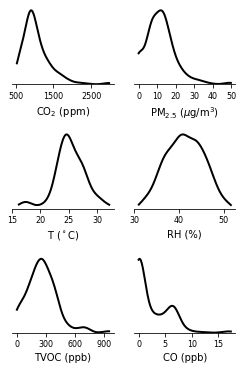

In [57]:
plot_summary(ieq_srsq,save=True)

In [104]:
np.mean(ieq_srsq["temperature_c_median"])

25.287313249414094

In [99]:
1 - len(ieq_srsq[ieq_srsq["co_median"]<=6.1])/len(ieq_srsq["co_median"])

0.19047619047619047

In [98]:
ieq_srsq[ieq_srsq["co_median"]>8.7]["beiwe"].value_counts()

rnse61g4    4
xdbdrk6e    3
zdpffrox    1
itmylz3g    1
Name: beiwe, dtype: int64

In [105]:
len(ieq_srsq)

273

### Surveys per Week

In [111]:
week_of_year = ieq_srsq.copy()
woy = []
for t in week_of_year["timestamp"]:
    woy.append(t.isocalendar()[1])
week_of_year["WoY"] = woy

In [116]:
week_of_year.groupby(["beiwe","WoY"]).count()["sol"].mean()

2.1496062992125986

### Performance Metrics

In [76]:
model_results = pd.DataFrame()
final_results = pd.DataFrame()
final_ft_importance = pd.DataFrame()
for target in ["tst","sol","naw","restful"]:
    agg_pred = ieq_and_sq_prediction()
    agg_pred.get_features_and_targets(ieq_bi,srsq,target)
    model_res, final_res, ft_importance = agg_pred.get_res(cv="")
    model_results = model_results.append(model_res)
    final_results = final_results.append(final_res)
    #final_res["f1_naive"] = round(f1_score(agg_pred.targets,np.ones(len(agg_pred.targets))),2)
    temp = pd.DataFrame(ft_importance).T
    temp.columns = [col.split("_")[0] for col in agg_pred.features.columns]
    final_ft_importance = final_ft_importance.append(temp)

Getting Features and Target (tst)...
Total: 272
Total: 272
Total: 272
Total: 272
Getting Features and Target (sol)...
Total: 272
Total: 272
Total: 272
Total: 272
Getting Features and Target (naw)...
Total: 272
Total: 272
Total: 272
Total: 272
Getting Features and Target (restful)...
Total: 272
Total: 272
Total: 272
Total: 272


In [77]:
results = model_results[["model","target","accuracy"]].merge(final_results,on=["model","target"],suffixes=["_train","_test"])
print(results.replace({"tst_binary":"TST","sol_binary":"SOL","naw_binary":"NAW","restful_binary":"Restful",
                             "logistic_regression":"LR","naive_bayes":"NB","decision_tree":"DT","random_forest":"RF"}).set_index("target").to_latex())

\begin{tabular}{llrrrlr}
\toprule
{} & model &  accuracy\_train &  accuracy\_test &  accuracy\_naive &           f1 &  f1\_naive \\
target  &       &                 &                &                 &              &           \\
\midrule
TST     &    LR &            0.65 &           0.64 &            0.64 &  0.79 (0.51) &      0.78 \\
TST     &    NB &            0.65 &           0.64 &            0.64 &  0.78 (0.51) &      0.78 \\
TST     &    DT &            0.72 &           0.54 &            0.64 &  0.78 (0.05) &      0.78 \\
TST     &    RF &            0.71 &           0.54 &            0.64 &  0.78 (0.11) &      0.78 \\
SOL     &    LR &            0.58 &           0.41 &            0.52 &  0.68 (0.38) &      0.68 \\
SOL     &    NB &            0.57 &           0.44 &            0.52 &  0.68 (0.36) &      0.68 \\
SOL     &    DT &            0.70 &           0.46 &            0.52 &  0.69 (0.04) &      0.68 \\
SOL     &    RF &            0.69 &           0.47 &            0.5

### Feature Importance

In [78]:
print(final_ft_importance.drop(["logistic_regression","naive_bayes"],axis=0).rename({"decision_tree":"DT","random_forest":"RF"},axis=0).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &       co2 &        co &      tvoc &     pm2p5 &  temperature &        rh \\
\midrule
DT &  0.176660 &  0.100194 &  0.236781 &  0.158222 &     0.154267 &  0.173876 \\
RF &  0.169217 &  0.212763 &  0.151445 &  0.151484 &     0.153916 &  0.161176 \\
DT &  0.103315 &  0.212703 &  0.160102 &  0.148000 &     0.222572 &  0.153309 \\
RF &  0.217519 &  0.202073 &  0.117290 &  0.133096 &     0.144318 &  0.185704 \\
DT &  0.115892 &  0.224538 &  0.229465 &  0.182624 &     0.145569 &  0.101911 \\
RF &  0.182363 &  0.175702 &  0.183205 &  0.140324 &     0.129403 &  0.189004 \\
DT &  0.195758 &  0.142405 &  0.160355 &  0.112575 &     0.151779 &  0.237127 \\
RF &  0.183335 &  0.174558 &  0.167147 &  0.133697 &     0.180371 &  0.160892 \\
\bottomrule
\end{tabular}



## Class Distinction

In [31]:
comb = ieq.merge(right=srsq,on=["beiwe","end_date"])
comb.head()

,beiwe,start_time,end_time,tvoc_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,fitbit_median,end_date,timestamp,redcap,beacon,tst,sol,naw,restful,tst_binary,sol_binary,naw_binary,restful_binary
0,4i7679py,2020-07-22 06:08:00,2020-07-22 09:46:30,87.556903,6.128722,634.789367,0.000000,28.045646,49.836667,38.0,2020-07-22,2020-07-22 11:29:58,37,44.0,3.0,5.0,2.0,0.0,0,1,0,0
1,4i7679py,2020-08-05 05:02:30,2020-08-05 09:52:30,59.919139,5.997469,590.241211,0.000000,28.045646,47.466667,38.0,2020-08-05,2020-08-05 16:34:21,37,44.0,4.0,7.0,1.0,1.0,0,1,1,0
2,745vq78e,2020-06-15 03:45:00,2020-06-15 10:02:30,241.392272,3.170915,1487.851814,17.101568,26.892072,40.281667,47.0,2020-06-15,2020-06-15 16:32:19,55,5.0,5.5,0.0,0.0,2.0,0,1,1,1
3,745vq78e,2020-06-19 05:00:00,2020-06-19 12:27:30,352.362719,3.085837,1497.211708,23.513718,27.666598,40.117544,47.0,2020-06-19,2020-06-19 12:31:11,55,5.0,6.6,0.0,1.0,2.0,0,1,1,1
4,745vq78e,2020-06-21 05:31:00,2020-06-21 11:11:30,170.356582,2.940209,1688.836099,4.212862,27.457523,40.273333,47.0,2020-06-21,2020-06-21 23:38:53,55,5.0,5.0,0.0,0.0,2.0,0,1,1,1


In [21]:
def plot_feature_relationships(df,iaq_p1="co2",iaq_p2="co",target="tst",save=False):
    """
    Plots the relationship between three features
    
    Parameters
    ----------
    
    Returns
    -------
    <void>
    """
    # defining arrays
    x = df.loc[:,f"{iaq_p1}_median"]
    y = df.loc[:,f"{iaq_p2}_median"]
    z = df.loc[:,f"{target}_binary"]
    
    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(6,6)
    
    im0=ax.scatter(x[z==0], y[z==0], alpha=0.6, marker='o',s=100,color="cornflowerblue",edgecolor="black",label = 'Class 0')
    im=ax.scatter(x[z==1], y[z==1], alpha=0.6,marker='^',s=100,color="firebrick",edgecolor="black", label = 'Class 1')
    
    ax.set_xlabel(f'{visualize.get_label(iaq_p1)} ({visualize.get_units(iaq_p1)})',fontsize=18)
    ax.set_ylabel(f'{visualize.get_label(iaq_p2)} ({visualize.get_units(iaq_p2)})',fontsize=18)
    ax.legend([im0,im],["Class 0","Class 1"],fontsize=18,loc='upper right',frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    
    if save:
        plt.savefig(f"../reports/figures/prediction/sleep_quality-feature_relationship-{iaq_p1}-{iaq_p2}-{target}.pdf",bbox_inches="tight")
    
    plt.show()
    plt.close()

In [22]:
plot_feature_relationships(comb,"pm2p5_mass","tvoc")

NameError: name 'comb' is not defined

In [23]:
plot_feature_relationships(comb,"rh","co2","sol")

NameError: name 'comb' is not defined

In [24]:
plot_feature_relationships(comb,"co","temperature_c","naw")

NameError: name 'comb' is not defined

In [25]:
plot_feature_relationships(comb,"pm2p5_mass","tvoc","restful")

NameError: name 'comb' is not defined

In [39]:
def plot_feature_relationships_binary(df,iaq_p1="co2",iaq_p2="co",target="tst",save=False):
    """
    Plots the relationship between three features
    
    Parameters
    ----------
    
    Returns
    -------
    <void>
    """
    #df_important = df[[f"{iaq_p1}_median_binary",f"{iaq_p2}_median_binary",f"{target}_binary"]]
    class0 = []
    class1 = []
    for i in [1,0]:
        for j in [1,0]:
            reduced = df[(df[f"{iaq_p1}_median_binary"] == i) & (df[f"{iaq_p2}_median_binary"] == j)]
            class0.append(len(reduced[reduced[f"{target}_binary"] == 0]))#/len(reduced)*100)
            class1.append(len(reduced[reduced[f"{target}_binary"] == 1]))#/len(reduced)*100)
    
    labels = ["$\ell$, $\ell$","$\ell$, h","h, $\ell$","h, h",]
    
    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(6,6)
    
    im0=ax.bar(labels,class0,color="firebrick",edgecolor="black",label = 'Poor')
    im=ax.bar(labels,class1,bottom=class0,color="cornflowerblue",edgecolor="black", label = 'Satisfactory')
    
    ax.set_xlabel(f'{visualize.get_label(iaq_p1)}, {visualize.get_label(iaq_p2)}',fontsize=18)
    ax.set_ylabel(f'Count',fontsize=18)
    #ax.set_ylim([0,100])
    ax.legend([im0,im],["Poor","Satisfactory"],title=target.upper(),title_fontsize=16,fontsize=14,loc='upper center',bbox_to_anchor=(1.2,0.9),frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    
    if save:
        plt.savefig(f"../reports/figures/prediction/sleep_quality-feature_relationship-{iaq_p1}-{iaq_p2}-{target}.pdf",bbox_inches="tight")
    
    plt.show()
    plt.close()

In [40]:
comb2 = ieq_bi.merge(right=srsq,on=["beiwe","end_date"])

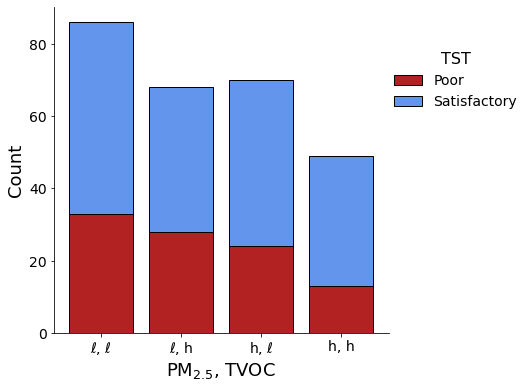

In [41]:
plot_feature_relationships_binary(comb2,"pm2p5_mass","tvoc","tst",save=True)

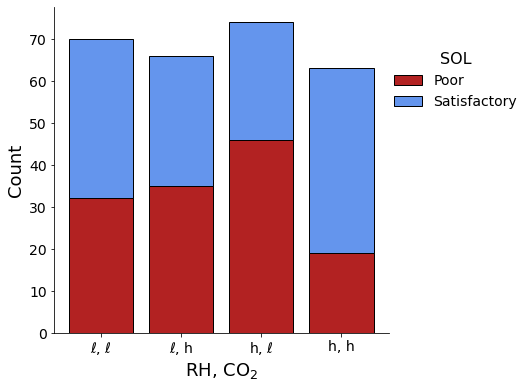

In [44]:
plot_feature_relationships_binary(comb2,"rh","co2","sol",save=True)

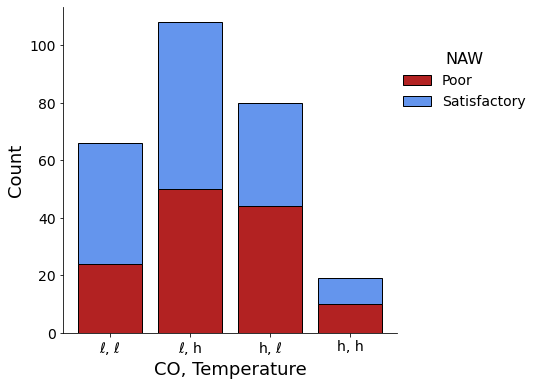

In [45]:
plot_feature_relationships_binary(comb2,"co","temperature_c","naw",save=True)

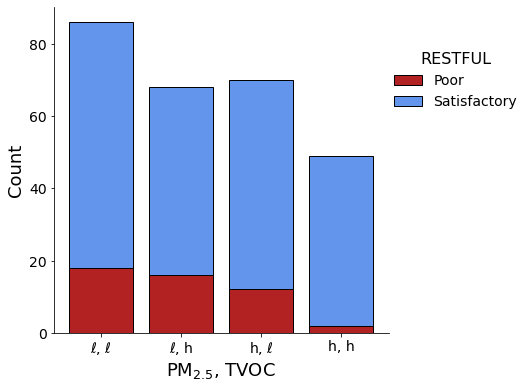

In [46]:
plot_feature_relationships_binary(comb2,"pm2p5_mass","tvoc","restful",save=True)